<a href="https://colab.research.google.com/github/helloworld0622/DDPG-for-optimal-trading-strategies-in-the-stock-market/blob/main/DDPG_TRADITIONAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
## install finrl library
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.23
    Uninstalling SQLAlchemy-2.0.23:
      Successfully uninstalled SQLAlchemy-2.0.23
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.50 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...
Select

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [ ]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [ ]:
# from config.py, TRAIN_START_DATE is a string
TRAIN_START_DATE
# from config.py, TRAIN_END_DATE is a string
TRAIN_END_DATE

'2020-07-31'

In [ ]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-31'
TRADE_START_DATE = '2021-11-01'
TRADE_END_DATE = '2023-12-01'

In [ ]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [ ]:
df.shape

(102743, 8)

In [ ]:
import_30_stock_data = df.sort_values(['date', 'tic'], ignore_index=True).head()
import_30_stock_data.to_csv('/content/import_30_stock_data.csv', index=False)
from google.colab import files
files.download('/content/import_30_stock_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (3501, 8)
Successfully added vix
Successfully added turbulence index


In [ ]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [ ]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)



,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,AAPL,7.622500,7.660714,7.585000,6.479000,493729600.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,6.479000,6.479000,20.040001,0.0
1,2010-01-04,AMGN,56.630001,57.869999,56.560001,41.817783,5277400.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,41.817783,41.817783,20.040001,0.0
2,2010-01-04,AXP,40.810001,41.099998,40.389999,33.300190,6894300.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,33.300190,33.300190,20.040001,0.0
3,2010-01-04,BA,55.720001,56.389999,54.799999,43.777550,6186700.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,43.777550,43.777550,20.040001,0.0
4,2010-01-04,CAT,57.650002,59.189999,57.509998,40.523609,7325600.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,40.523609,40.523609,20.040001,0.0
5,2010-01-04,CRM,18.652500,18.882500,18.547501,18.705000,7906000.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,18.705000,18.705000,20.040001,0.0
6,2010-01-04,CSCO,24.110001,24.840000,24.010000,17.011654,59853700.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,17.011654,17.011654,20.040001,0.0
7,2010-01-04,CVX,78.199997,79.199997,78.160004,45.479122,10173800.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,45.479122,45.479122,20.040001,0.0
8,2010-01-04,DIS,32.500000,32.750000,31.870001,27.843178,13700400.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,27.843178,27.843178,20.040001,0.0
9,2010-01-04,GS,170.050003,174.250000,169.509995,136.536926,9135000.0,0.0,0.0,6.50044,6.46876,100.0,66.666667,100.0,136.536926,136.536926,20.040001,0.0


In [ ]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

In [ ]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(train_length)
print(trade_length)

86362
15167


In [ ]:
train_example = train.tail()
train_example.to_csv('/content/train_example.csv', index=False)
from google.colab import files
files.download('/content/train_example.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_example = train.head()
train_example.to_csv('/content/train_example.csv', index=False)
from google.colab import files
files.download('/content/train_example.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [ ]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [ ]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [ ]:
agent = DRLAgent(env = env_train)

if_using_a2c = False
if_using_ddpg = True
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 70        |
|    time_elapsed    | 167       |
|    total_timesteps | 11912     |
| train/             |           |
|    actor_loss      | -66.4     |
|    critic_loss     | 1.76e+03  |
|    learning_rate   | 0.001     |
|    n_updates       | 8934      |
|    reward          | 2.0215712 |
----------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 67        |
|    time_elapsed    | 353       |
|    total_timesteps | 23824     |
| train/             |           |
|    actor_loss      | -25.4     |
|    critic_loss     | 15.9      |
|    learning_rate   | 0.001     |
|    n_updates       | 20846     |
|    reward          | 2.0215712 |
----------------------------------
day: 2977, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5359747.07
total_rew

In [ ]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [ ]:
insample_risk_indicator.vix.describe()

count    2978.000000
mean       18.103627
std         7.249510
min         9.140000
25%        13.390000
50%        16.235000
75%        20.629999
max        82.690002
Name: vix, dtype: float64

In [ ]:
insample_risk_indicator.vix.quantile(0.996)

57.14900183105476

In [ ]:
insample_risk_indicator.turbulence.describe()

count    2978.000000
mean       34.227341
std        43.854481
min         0.000000
25%        14.669001
50%        23.650876
75%        38.457600
max       652.504725
Name: turbulence, dtype: float64

In [ ]:
insample_risk_indicator.turbulence.quantile(0.996)

289.66704233163193

In [ ]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-11-01,AAPL,148.990005,149.699997,147.800003,147.062637,74588300.0,0.0,1.277839,151.486924,137.189601,53.745455,83.738586,4.922968,143.496621,145.573657,16.41,21.714246
0,2021-11-01,AMGN,208.000000,212.089996,207.770004,194.917542,3105300.0,0.0,-1.609489,197.426036,188.279184,44.297381,0.925544,8.685633,194.719345,200.886613,16.41,21.714246
0,2021-11-01,AXP,174.580002,176.070007,173.339996,169.472916,2250400.0,0.0,1.885553,179.293728,163.457433,52.381485,-4.977903,3.946445,169.738272,164.134308,16.41,21.714246
0,2021-11-01,BA,207.000000,214.690002,206.809998,214.580002,9284900.0,0.0,-2.888246,230.504990,203.869009,46.938895,-80.065736,10.696893,218.312666,219.090167,16.41,21.714246
0,2021-11-01,CAT,204.289993,206.880005,203.809998,196.637619,3215200.0,0.0,1.398967,199.140463,178.485393,52.511579,146.256339,17.811531,187.845408,193.593736,16.41,21.714246


In [ ]:
trained_moedl = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_moedl,
    environment = e_trade_gym)

hit end!


In [ ]:
df_account_value_ddpg.shape

(523, 2)

In [ ]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

In [ ]:
def StockReturnsComputing(StockPrice, Rows, Columns):
  import numpy as np
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

In [ ]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [ ]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[147.063, 194.918, 169.473, ...,  46.767,  41.789, 144.674],
       [148.109, 199.071, 168.461, ...,  46.431,  42.168, 144.606],
       [149.56 , 202.666, 167.916, ...,  46.758,  43.475, 145.05 ],
       ...,
       [189.79 , 264.27 , 164.04 , ...,  37.35 ,  20.11 , 156.19 ],
       [190.4  , 265.52 , 165.66 , ...,  37.47 ,  19.98 , 158.053],
       [189.37 , 266.6  , 167.43 , ...,  37.76 ,  19.98 , 155.502]])

In [ ]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.121 0.063 0.071 0.077 0.07  0.118 0.052 0.043 0.073 0.052 0.106 0.078
 0.021 0.057 0.048 0.073 0.041 0.064 0.046 0.053 0.101 0.096 0.047 0.059
 0.109 0.092 0.043 0.033 0.05 ]
Variance-Covariance matrix of returns
 [[3.127 1.013 1.287 1.52  1.373 1.687 1.373 1.124 1.087 1.373 1.161 1.22
  1.03  1.522 0.691 1.269 0.663 0.815 1.029 0.736 1.572 1.137 0.668 0.86
  1.143 1.334 0.525 0.907 0.634]
 [1.013 2.397 1.071 1.009 1.065 1.209 1.024 0.964 0.937 1.121 0.977 1.028
  0.851 1.151 0.89  1.14  0.639 0.663 0.906 1.072 1.085 0.872 0.723 0.853
  1.144 1.057 0.631 1.024 0.645]
 [1.287 1.071 3.313 2.472 1.903 1.565 1.425 1.92  1.714 2.234 1.374 1.844
  1.342 1.507 0.86  2.367 0.987 1.071 1.374 0.959 1.353 1.416 0.727 1.503
  1.414 1.804 0.747 1.217 0.584]
 [1.52  1.009 2.472 4.957 2.117 1.685 1.508 2.14  1.837 2.199 1.525 2.119
  1.531 1.698 0.904 2.295 1.115 1.192 1.46  0.949 1.433 1.571 0.746 1.603
  1.47  1.717 0.733 1.362 0.603]
 [1.373 1.065 1.903 

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([258950.,      0.,      0.,      0.,      0.,  64040.,      0.,
            0.,      0.,      0., 315950.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,  28830.,
        81760.,      0.,      0., 250480.,      0.,      0.,      0.,
            0.])

In [ ]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1750.941,    0.   ,    0.   ,    0.   ,    0.   ,  213.687,
          0.   ,    0.   ,    0.   ,    0.   ,  899.254,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,   88.692,  501.268,    0.   ,    0.   ,
        561.051,    0.   ,    0.   ,    0.   ,    0.   ])

In [ ]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
# MVO_result

In [ ]:
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value_ddpg['date']
df_dji['dji_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
#result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
print(result.head())
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
# result.columns = ['ddpg' 'mean var', 'dji']

# print("result: ", result)
result.to_csv("result.csv")

==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (524, 8)
Annual return          0.000496
Cumulative returns     0.001032
Annual volatility      0.162524
Sharpe ratio           0.084233
Calmar ratio           0.002261
Stability              0.001174
Max drawdown          -0.219408
Omega ratio            1.014307
Sortino ratio          0.118783
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.998985
Daily value at risk   -0.020422
dtype: float64
                    ddpg
date                    
2021-11-01  1.000000e+06
2021-11-02  1.001985e+06
2021-11-03  1.002411e+06
2021-11-04  1.000343e+06
2021-11-05  9.962157e+05


In [ ]:
import pandas as pd

# Assuming df_account_value_ddpg contains the daily portfolio value of your DDPG strategy

# Compute statistics for DDPG strategy
ddpg_stats = backtest_stats(df_account_value_ddpg, value_col_name='account_value')

# Compute statistics for DJI as you have already done
df_dji_ = get_baseline(ticker="^DJI", start=TRADE_START_DATE, end=TRADE_END_DATE)
dji_stats = backtest_stats(df_dji_, value_col_name='close')

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Metric': ['Annual return', 'Cumulative returns', 'Annual volatility', 'Sharpe ratio',
               'Calmar ratio', 'Stability', 'Max drawdown', 'Omega ratio', 'Sortino ratio',
               'Tail ratio', 'Daily value at risk'],
    'DDPG': [ddpg_stats[m] for m in ['Annual return', 'Cumulative returns', 'Annual volatility',
                                      'Sharpe ratio', 'Calmar ratio', 'Stability', 'Max drawdown',
                                      'Omega ratio', 'Sortino ratio', 'Tail ratio', 'Daily value at risk']],
    'DJI': [dji_stats[m] for m in ['Annual return', 'Cumulative returns', 'Annual volatility',
                                    'Sharpe ratio', 'Calmar ratio', 'Stability', 'Max drawdown',
                                    'Omega ratio', 'Sortino ratio', 'Tail ratio', 'Daily value at risk']]
})

# Display the comparison table
print(comparison_df)


Annual return          0.018034
Cumulative returns     0.037790
Annual volatility      0.153654
Sharpe ratio           0.193269
Calmar ratio           0.108549
Stability              0.102843
Max drawdown          -0.166134
Omega ratio            1.032557
Sortino ratio          0.275110
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.041765
Daily value at risk   -0.019241
dtype: float64
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (524, 8)
Annual return          0.000496
Cumulative returns     0.001032
Annual volatility      0.162524
Sharpe ratio           0.084233
Calmar ratio           0.002261
Stability              0.001174
Max drawdown          -0.219408
Omega ratio            1.014307
Sortino ratio          0.118783
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.998985
Daily value at risk   -0.020422
dtype: float64
                 Metric      DDPG      

In [ ]:
df_result_ddpg

,ddpg
date,
2021-11-01,1.000000e+06
2021-11-02,1.001985e+06
2021-11-03,1.002411e+06
2021-11-04,1.000343e+06
2021-11-05,9.962157e+05
...,...
2023-11-22,1.033048e+06
2023-11-24,1.037128e+06
2023-11-27,1.035698e+06


<Figure size 1500x500 with 0 Axes>

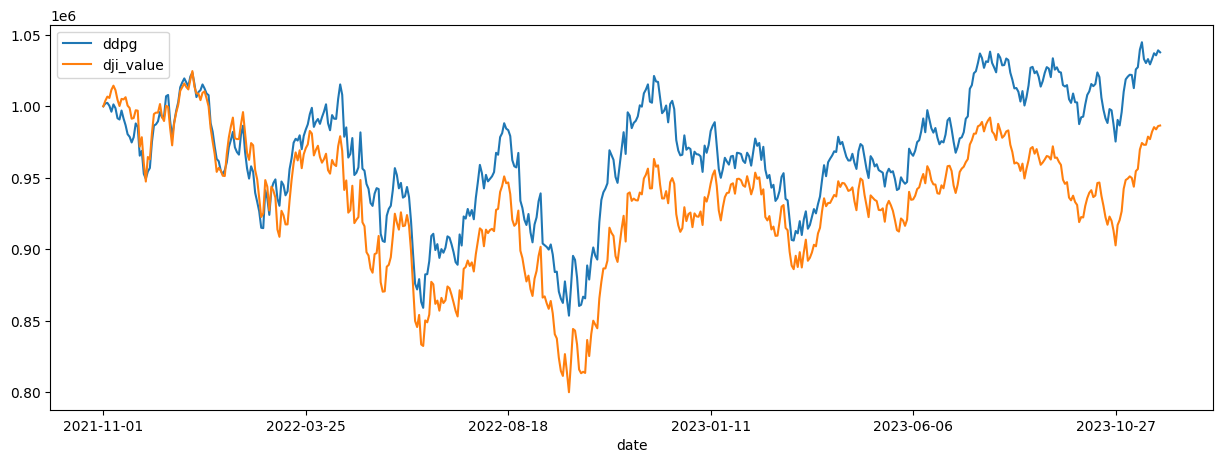

In [ ]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();